# Insights from medical posts


In this notebook, I try to find characteristics of medical posts.

1. What is the ratio of post from professionals vs. those from general public?   
2. What are the characteristics that well-separate professional-level posts?   
  * Length of text   
  * Usage of offending vocabulary   
  * Writing level   
  

In [1]:

# Set up paths/ os
import os
import sys

this_path=os.getcwd()
os.chdir("../data")
sys.path.insert(0, this_path)


In [2]:
# Load datasets
import pandas as pd

df =  pd.read_csv("MedHelp-posts.csv",index_col=0)
df.head(2)

,title,text,href,user id,mother post id
post id,,,,,
1,Inappropriate Masterbation Down Syndrome,\n It is common for children and adoles...,http://www.medhelp.org//posts/Autism--Asperger...,user_340688,1
2,Inappropriate Masterbation Down Syndrome,"\n A related discussion, self injusry i...",http://www.medhelp.org//posts/Autism--Asperger...,user_1566928,1


In [3]:
df_users = pd.read_csv("MedHelp-users.csv",index_col=0)
df_users.head(2)

,user description
user id,
user_340688,"Rachel Thompson, Ph.D., BCBA"
user_1566928,CirclesLady29


In [4]:
# 1 classify users as professionals and general public:

df_users['is expert']=0

for user_id in df_users.index:
    user_description=df_users.loc[user_id,['user description']].values
    if ( "," in user_description[0]):
        print(user_description[0])
        df_users.loc[user_id,['is expert']]=1



Rachel  Thompson, Ph.D., BCBA
Myrna  Libby, Ph.D., BCBA
Jason C Bourret, Ph.D., BCBA-D
Tali  Shenfield, PhD
Richard B. Graff, PhD, BCBA-D
Jessica L Thomason Sassi, Ph.D., BCBA-D
William L. Holcomb, Ph.D., BCBA-D
Eileen  Roscoe, PhD
Rebecca  MacDonald, Ph.D., BCBA
William H Ahearn, Ph.D., BCBA


In [5]:
is_expert=df_users['is expert'] == 1
is_expert.value_counts()

False    495
True      10
Name: is expert, dtype: int64

Only **10 out of 505** users are experts!   
This corresponds to **2 %** of users.

In [6]:
# Select user_id from DB where is_professional = 1
experts_ids = df_users[df_users['is expert'] == 1 ].index.values
experts_ids

non_experts_ids = df_users[df_users['is expert'] == 0 ].index.values

In [7]:
# Select * where user_id in experts_ids
#df_users.loc[df_users.index.isin(experts_ids)]

df_experts=df.loc[df['user id'].isin(experts_ids)]
print('Total of posts from expert users {}'.format(len(df_experts)))
print('Total of posts {}'.format(len(df)))
print('Ratio {}'.format(len(df_experts)/len(df)))
del df_experts

Total of posts from expert users 727
Total of posts 1813
Ratio 0.40099282956425814


# Length ot text

In [8]:
# Tokenize data
import nltk
tokenizer = nltk.RegexpTokenizer(r'\w+')

# Get the length of tokens into a columns
df_text = df['text'].str.lower()
df_token = df_text.apply(tokenizer.tokenize)
df['token length'] = df_token.apply(len)




# Get list of tokens from text in first article:

#for text in df_text.values:
#    ttext = tokenizer.tokenize(text.lower())
#    lenght_text=len(ttext)
#    break

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
from matplotlib import gridspec
from scipy.stats import norm
import numpy as np
from scipy.optimize import curve_fit
from lognormal import lognormal, lognormal_stats,truncated_normal
from scipy.stats import truncnorm


In [10]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True

plt.rcParams.update({'font.size': 24})

nbins=100


fig = plt.figure()
#fig=plt.figure(figsize=(2,1))
#fig.set_size_inches(6.6,3.3)
gs = gridspec.GridSpec(2, 1)
#plt.subplots_adjust(left=0.1,right=1.0,bottom=0.17,top=0.9)


#plt.suptitle('Text length (words count)')
fig.text(0.04,0.5,'Distribution',va='center',rotation='vertical')

[ 96.97554606  52.03452703]
Class 0: Mean,variance: (176.15745856353593,37789.182389121204)
Class 1: Mean,variance: (159.5126437825775, 14611.355984084914)


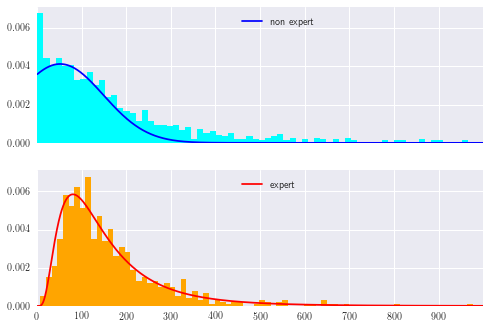

In [13]:
#X ticks

xmax=1000
x=np.arange(0,xmax,100) #xtics
xx=np.arange(1,xmax,1)

# Panel 1
ax1=plt.subplot(gs[0])
ax1.set_xlim([0, xmax])
ax1.set_xticks(x)
ax1.tick_params(labelbottom='off')    


#plt.ylabel('')
#Class 0
X=df.loc[df['user id'].isin(non_experts_ids)]['token length'].values
n,bins,patches=plt.hist(X,nbins,normed=1,facecolor='cyan',align='mid')

popt,pcov = curve_fit(truncated_normal,bins[:nbins],n)
plt.legend(handles=[c0],bbox_to_anchor=(0.45, 0.95), loc=2, borderaxespad=0.)


c0,=plt.plot(xx,truncated_normal(xx,*popt),color='blue',label='non expert')

print(popt)
mu=X.mean()
var=X.var()
print("Class 0: Mean,variance: ({},{})".format(mu,var))



# Panel 2
ax2=plt.subplot(gs[1])
ax2.set_xlim([0, xmax])
ax2.set_xticks(x)
#ax2.set_yticks(np.arange(0,8,2))
#plt.ylabel('Normal distribution')

#Class 1
X=df.loc[df['user id'].isin(experts_ids)]['token length'].values
#(mu,sigma) = norm.fit(X)
n,bins,patches=plt.hist(X,nbins,normed=1,facecolor='orange',align='mid')
popt,pcov = curve_fit(lognormal,bins[:nbins],n)
#c1,=plt.plot(xx,mlab.normpdf(xx, mu, sigma),color='darkorange',label='layered')
c1,=plt.plot(xx,lognormal(xx,*popt),color='red',label='expert')
plt.legend(handles=[c1],bbox_to_anchor=(0.45, 0.95), loc=2, borderaxespad=0.)
print("Class 1: Mean,variance:",lognormal_stats(*popt))


#plt.xlabel('Volume ratio (theor./expt.)')

plt.show()